In [2]:
import pywavefront
import numpy as np
from __future__ import print_function
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

ImportError: No module named 'pywavefront'

In [3]:
# read in face model
scene = pywavefront.Wavefront('swift-2-in_mesh.obj')
data = np.array(scene.vertices)
print(data.shape)

NameError: name 'pywavefront' is not defined

In [84]:
# return a column from matrix
def column(matrix, i):
    return np.array([row[i] for row in matrix])

In [85]:
# round data of an give axis and sort it
def roundAxis(data,axis):
    for i in range(len(data)):
        data[i][axis] = int(data[i][axis]/10)*10
    data = sorted(data, key = lambda x:x[axis])
    return data

In [97]:
# return an array
# If the data value differs from the previous value,
# its index i would be append to array
def createIndex(data,step):
    i = 0
    value = np.amin(data)
    up = np.amax(data)
    index=[0]
    while value <= up:
        while i < len(data) and data[i] <= value:
            i+=1
        index.append(i-1)
        value +=step
    index.append(len(data)-1)
    return index

In [87]:
# round x axis
data_roundX = data.copy()
data_roundX = roundAxis(data_roundX,0)
x_train_X = column(data_roundX,0).reshape(-1,1)
y_train_X = column(data_roundX,1).reshape(-1,1)
z_train_X = column(data_roundX,2).reshape(-1,1)

X_train_X = np.hstack((x_train_X,y_train_X))

In [88]:
# round y axis
data_roundY = roundAxis(data,1)
x_train_Y = column(data_roundY,0).reshape(-1,1)
y_train_Y = column(data_roundY,1).reshape(-1,1)
z_train_Y = column(data_roundY,2).reshape(-1,1)

X_train_Y = np.hstack((x_train_Y,y_train_Y))

In [98]:
# generate index for x axis and y axis
x_index = createIndex(x_train_X,10)
y_index = createIndex(y_train_Y,10)

[0,
 49,
 639,
 1586,
 2708,
 3950,
 5212,
 6517,
 7891,
 9317,
 10636,
 11887,
 13121,
 14533,
 15807,
 17198,
 18622,
 19966,
 21253,
 22496,
 23706,
 24819,
 25786,
 26513,
 26755,
 26755]

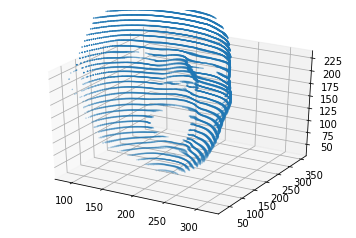

In [120]:
# visualize the face after cutting in lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_Y, y_train_Y, z_train_Y,zdir="y",s =0.1)

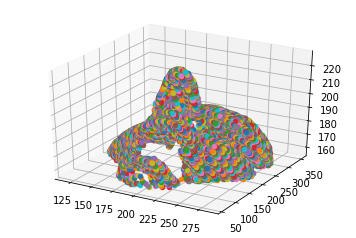

In [101]:
# set hyperparameters
learning_rate = 0.01
epsilon = 1
batch_size = 100
display_step = 100

# build neural networks layers
x = tf.placeholder(tf.float32,[None, 2])
y = tf.placeholder(tf.float32, [None, 1])

W1 = tf.Variable(tf.random.normal([2,16]),tf.float32)
b1 = tf.Variable(tf.zeros([16]),tf.float32)
W2 = tf.Variable(tf.random.normal([16,32]),tf.float32)
b2 = tf.Variable(tf.zeros([32]),tf.float32)
W3 = tf.Variable(tf.random.normal([32,1]),tf.float32)
b3 = tf.Variable(tf.zeros([1]),tf.float32)

In [102]:
# calculate cost and set optimizer
x = tf.nn.dropout(x, keep_prob =0.8)
Z1 = tf.add(tf.matmul(x,W1),b1)
A1 = tf.nn.relu(Z1)

Z2 = tf.add(tf.matmul(A1,W2),b2)
A2 = tf.nn.relu(Z2)

Z3 = tf.add(tf.matmul(A2,W3),b3)
cost = tf.reduce_mean(tf.pow(y-Z3,2))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [4]:
# initialize two 3d plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

# run tensorflow session
with tf.Session() as sess :
    sess.run(init)
    i = 0
    while i < len(x_index)-1:
        cost_L = []
        epoch_L = []
        epoch = 0
        c_x = 10
        while epoch <= 1000 and c_x > epsilon:
            X = X_train_X[x_index[i]:x_index[i+1]]
            Y = z_train_X[x_index[i]:x_index[i+1]]
            _,c_x=sess.run([optimizer,cost],feed_dict={x:X, y:Y})
            epoch += 1
            if (epoch % 100 == 0):
                cost_L.append(c_x)
                epoch_L.append(epoch)
        plt.plot(epoch_L, cost_L)
        print("Epoch:", '%04d' % (epoch+1), "line=", '%03d'%i, "cost=", "{:.9f}".format(c_x))
        # draw x axis fitting lines
        ax.scatter(x_train_X[x_index[i]:x_index[i+1]],y_train_X[x_index[i]:x_index[i+1]],sess.run(Z3,feed_dict={x:X,y:Y}),s=0.1,zdir='y')
        i += 1
        
    i = 0
    while i < len(y_index)-1:   
        epoch = 0
        c_y = 10
        while epoch <= 1000 and c_y > epsilon and i < len(y_index):
            X = X_train_Y[y_index[i]:y_index[i+1]]
            Y = z_train_Y[y_index[i]:y_index[i+1]]
            _,c_y=sess.run([optimizer,cost],feed_dict={x:X, y:Y})
            epoch += 1
        print("Epoch:", '%04d' % (epoch+1), "line=", '%03d'%i, "cost=", "{:.9f}".format(c_y))
        # draw y axis fitting lines
        ax.scatter(x_train_Y[y_index[i]:y_index[i+1]],y_train_Y[y_index[i]:y_index[i+1]],sess.run(Z3,feed_dict={x:X,y:Y}),s=0.1,zdir='y')
        i += 1
    ##y = sess.run(Z3,feed_dict={x:x_test})
    print("Optimization Finished!")
   

NameError: name 'plt' is not defined

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
[[-2.49791771e-01 -7.58169889e-02  1.61528972e-03 -5.95122099e-01
   1.04564518e-01 -1.13686554e-01  1.37324035e-01 -3.18114877e-01
  -7.95686901e-01 -4.74917084e-01 -5.87690584e-02 -1.10191786e+00
  -9.26959038e-01 -6.89914450e-02 -1.11517608e-01  3.07902154e-02]
 [-3.30524296e-01 -1.22047901e+00 -7.38129541e-02 -2.05346435e-01
  -1.64754665e+00 -2.72226721e-01 -1.48669624e+00  8.50937307e-01
   6.36576056e-01  7.10913986e-02 -1.22960234e+00  1.67211413e+00
  -2.23718494e-01 -1.65118468e+00  2.25438457e-03 -1.15021157e+00]]


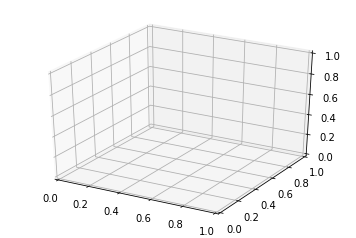

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess,"/tmp/model.ckpt")
    print(W1.eval())